# Model Selection: `model_2a` vs. `model_3a`

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
%autoreload 2

import os, glob, json, pickle
import matplotlib.pyplot as plt
import numpy as np

from enterprise.pulsar import Pulsar
from enterprise_extensions import models, model_utils, hypermodel

import sys
sys.path.append("..")
from settings import fd_bins

Do not have mpi4py package.


## Get par, tim, and noise files

In [2]:
psrlist = None # define a list of pulsar name strings that can be used to filter.
# set the data directory
datadir = '../data'
if not os.path.isdir(datadir):
    datadir = '../../data'
print('datadir =', datadir)

datadir = ../../data


In [3]:
# for the entire pta
parfiles = sorted(glob.glob(datadir + '/par/*par'))
timfiles = sorted(glob.glob(datadir + '/tim/*tim'))

# filter
if psrlist is not None:
    parfiles = [x for x in parfiles if x.split('/')[-1].split('.')[0] in psrlist]
    timfiles = [x for x in timfiles if x.split('/')[-1].split('.')[0] in psrlist]

# Make sure you use the tempo2 parfile for J1713+0747!!
# ...filtering out the tempo parfile... 
parfiles = [x for x in parfiles if 'J1713+0747_NANOGrav_12yv3.gls.par' not in x]

In [4]:
# check for file and load pickle if it exists:
pickle_loc = datadir + '/psrs.pkl'
if os.path.exists(pickle_loc):
    with open(pickle_loc, 'rb') as f:
        psrs = pickle.load(f)

# else: load them in slowly:
else:
    psrs = []
    ephemeris = 'DE438'
    for p, t in zip(parfiles, timfiles):
        psr = Pulsar(p, t, ephem=ephemeris)
        psrs.append(psr)

In [5]:
## Get parameter noise dictionary
noise_ng12 = datadir + '/channelized_12p5yr_v3_full_noisedict.json'

params = {}
with open(noise_ng12, 'r') as fp:
    params.update(json.load(fp))

* We want to be able to compute the Bayesian odds for a GWB in the data. This can be done using the hypermodel class, where we choose between a `model_2a` with a common (but uncorrelated) red process in the pulsars, and `model_3a` with Hellings and Downs correlated red noise.

## Setup dictionary of PTA models
* `model_2a` includes a common red noise term where (for this analysis) we set the spectral index to 13/3
* `model_3a` includes a Hellings and Downs correlated common red noise term where (for this analysis) we set the spectral index to 13/3
* We also change `n_gwbfreqs` to only include the lowest 5 frequencies in this analysis
* There are other model functions built into `enterprise_extensions`.
* Check out the doc strings of each function in the `models.py` file of `enterprise_extensions` for more information.

In [6]:
nmodels = 2
mod_index = np.arange(nmodels)

# Make dictionary of PTAs.
pta = dict.fromkeys(mod_index)
pta[0] = models.model_2a(psrs, psd='powerlaw', noisedict=params, n_gwbfreqs=5, gamma_common=13/3)
pta[1] = models.model_3a(psrs, psd='powerlaw', noisedict=params, n_gwbfreqs=5, gamma_common=13/3)

* In setting up the `HyperModel` in the next cell, we set weights to make the models sample more evenly.
* This will be taken into account when we compute the Bayes factor later.
* `log_weights` is a list with the same length as the models, and each entry is added to the corresponding log-likelihood
* To undo the weights, we will divide each fraction by the exponential of the `log_weights`

In [ ]:
super_model = hypermodel.HyperModel(pta)

## Sample

In [ ]:
outDir = '../../chains/ms_2a3a_chains'
sampler = super_model.setup_sampler(resume=True, outdir=outDir, sample_nmodel=True,)

Adding red noise prior draws...

Adding GWB uniform distribution draws...

Adding gw param prior draws...

Adding nmodel uniform distribution draws...



/Users/aaron/opt/anaconda3/envs/enterprise/lib/python3.9/site-packages/numpy/lib/arraysetops.py:270: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  ar = np.asanyarray(ar)


In [ ]:
# This will take about an hour to sample
# To sample it properly will take ~30 hours
# sampler for N steps
N = int(5e6)  # 5e6 is a good number for a real analysis 
x0 = super_model.initial_sample()

In [ ]:
# sample
# sampler.sample(x0, N, SCAMweight=30, AMweight=15, DEweight=50, )

In [ ]:
# uncomment this line if you sampled yourself:
# chain = np.loadtxt(outDir + '/chain_1.txt')

# this line will load the chains that we have provided:
chain = np.load(outDir + '/chain_1.npz')['arr_0']

burn = int(0.1 * chain.shape[0])
pars = np.loadtxt(outDir + '/pars.txt', dtype=np.unicode_)

ind_model = list(pars).index('nmodel')

In [ ]:
burn = int(0.25*chain.shape[0])
pars = np.loadtxt(outDir + '/pars.txt', dtype=np.unicode_)

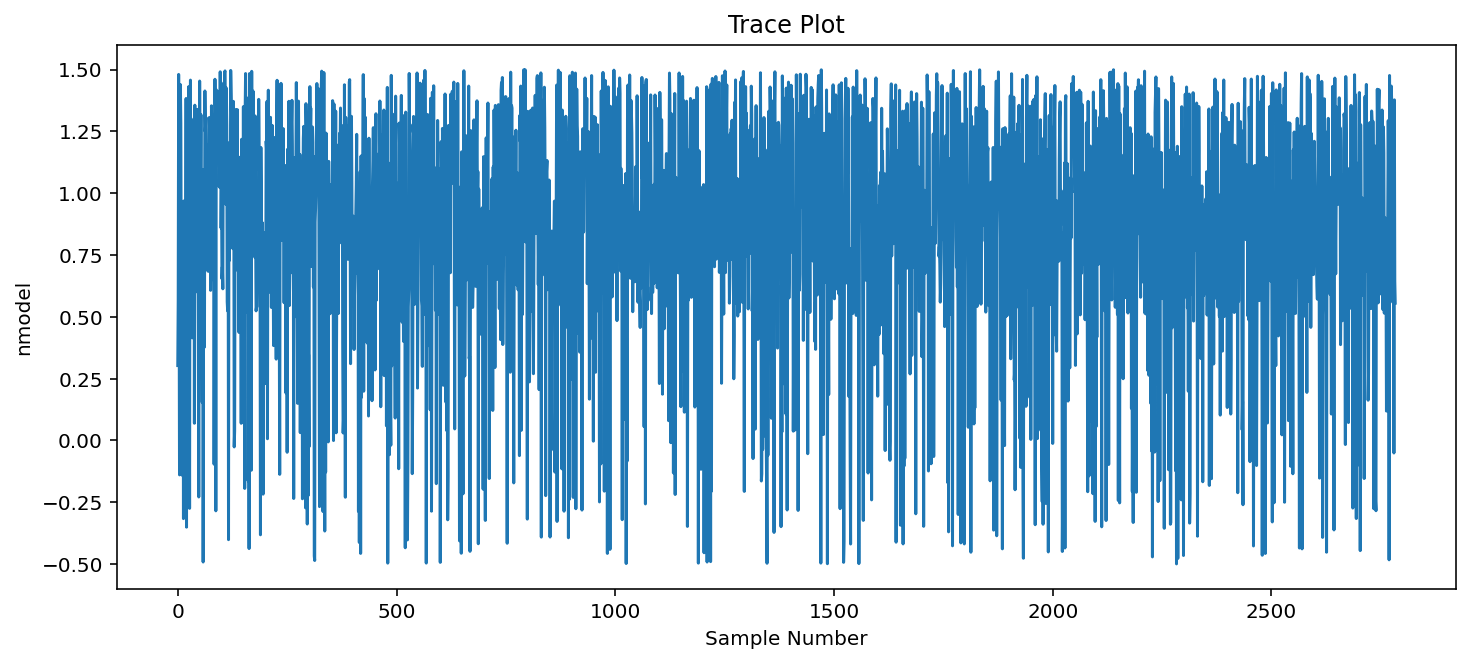

In [ ]:
# Make trace-plot to diagnose sampling
# We want this plot to look more like a fuzzy caterpillar than a skinny worm
plt.figure(figsize=(12, 5))
plt.plot(chain[burn:, ind_model])
plt.xlabel('Sample Number')
plt.ylabel('nmodel')
plt.title('Trace Plot')
plt.grid(b=True)
plt.show()

In [ ]:
# Plot histgram for GW amplitude
chain_burn = chain[burn:,:]

ind_model = list(pars).index('nmodel')
ind_gwamp = list(pars).index('gw_log10_A')

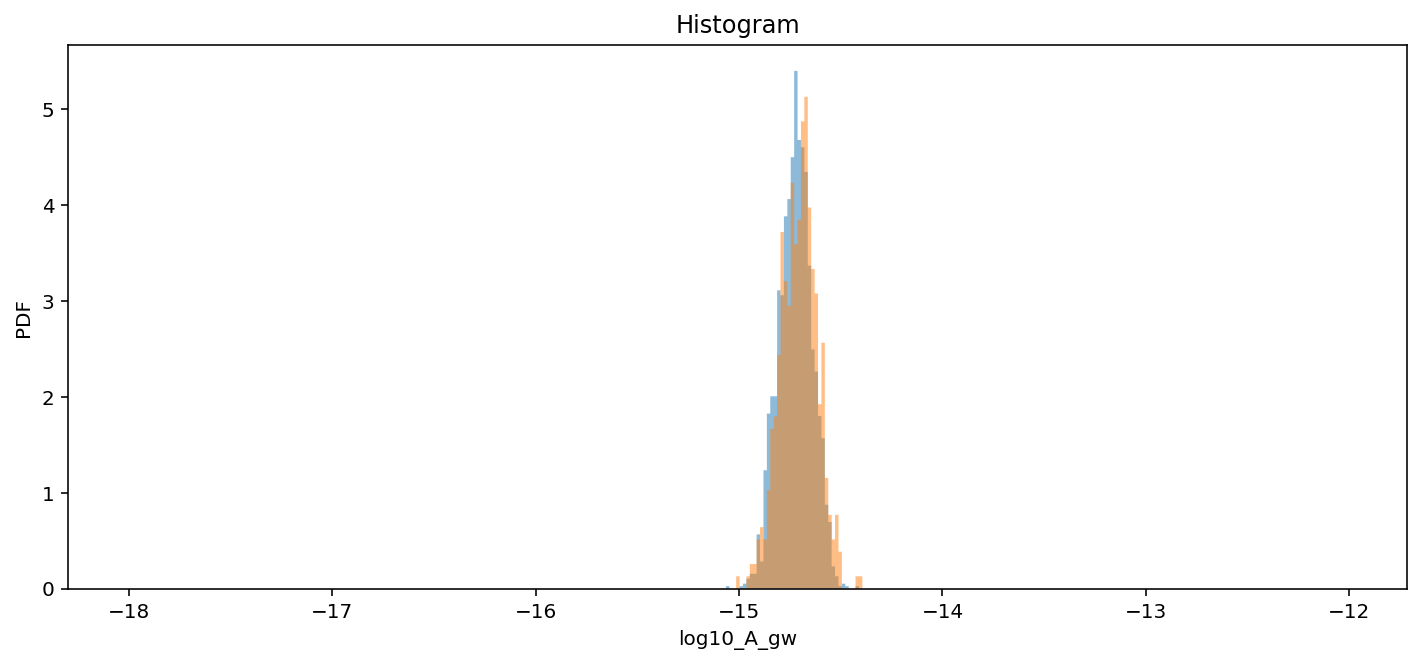

In [ ]:
# Plot a histogram of the marginalized posterior distribution for ind_model > 0.5 (includes common red process)
bins = fd_bins(chain_burn[chain_burn[:, ind_model] > 0.5, ind_gwamp], logAmin=-18, logAmax=-12)  # let FD rule decide bins (in ../settings.py)
plt.figure(figsize=(12, 5))
plt.title('Histogram')
plt.hist(chain_burn[chain_burn[:, ind_model] > 0.5, ind_gwamp], bins=bins, histtype='stepfilled',
         lw=2, color='C0', alpha=0.5, density=True)
plt.hist(chain_burn[chain_burn[:, ind_model] < 0.5, ind_gwamp], bins=bins, histtype='stepfilled',
         lw=2, color='C1', alpha=0.5, density=True)
plt.xlabel('log10_A_gw')
plt.ylabel('PDF')
plt.grid(b=True)
plt.show()

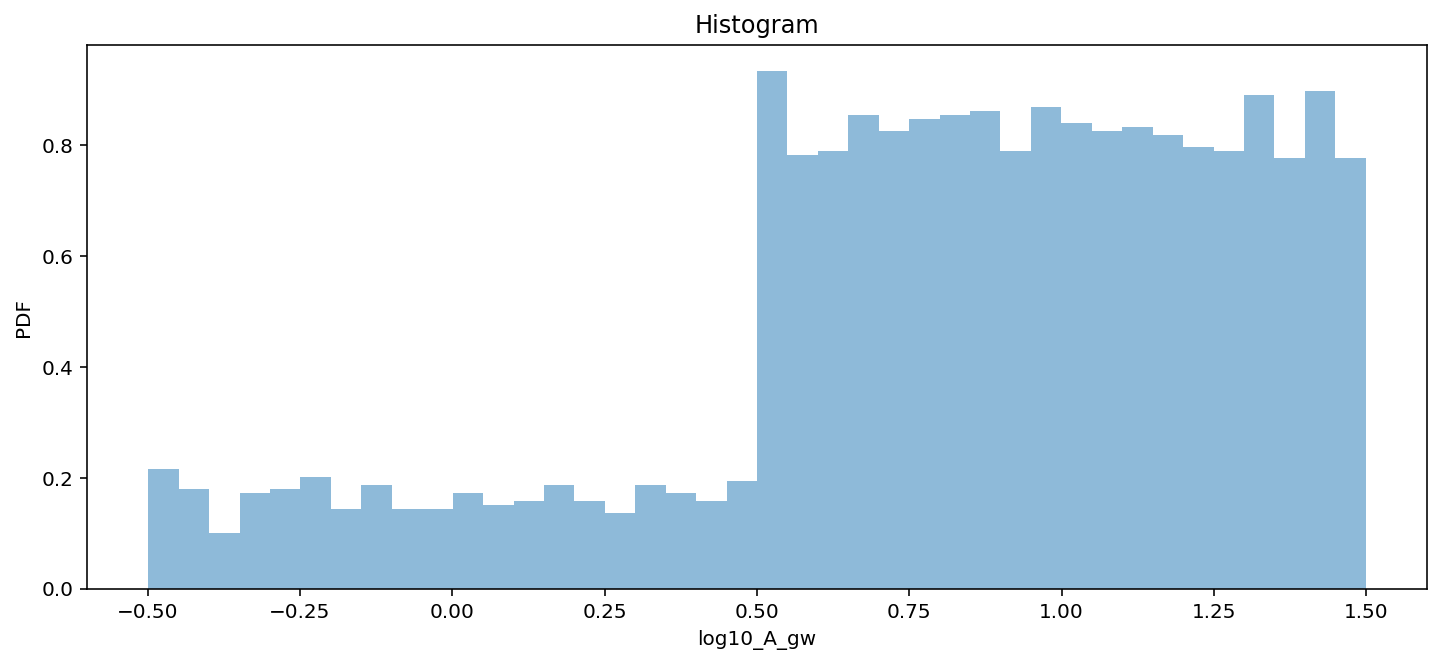

In [ ]:
# Plot histogram for GWB model selection
# This will tell us how much we have sampled for each model
plt.figure(figsize=(12, 5))
plt.title('Histogram')
plt.hist(chain_burn[:, ind_model], bins=40, histtype='stepfilled',
         lw=2, color='C0', alpha=0.5, density=True)
plt.xlabel('log10_A_gw')
plt.ylabel('PDF')
plt.grid(b=True)
plt.show()

### Hypermodel
* The hypermodel favors the second model (nmodel > 0.5)
* Because our models share the same priors, the posterior odds ratio and Bayes factor are the same.
* This shows that that `model_3a` is preferred, but still not strongly enough to claim a detection.

In [ ]:
# The first number is the Bayes factor (BF) and the second number is the uncertainty on the BF
bf, unc = model_utils.odds_ratio(chain_burn[:, ind_model], models=[0,1])
print(bf, unc)

4.987096774193549 0.25591994168688537


In [ ]:
log10bf = np.log10(bf)
print(log10bf)

0.6978477957480335


* Note that this Bayes factor is still a little low compared to the value found in the paper
* With more pulsars in the data set, we could recover the full log10BF of 4.5 for the `DE438` ephemeris.